# A Hypermetric Topic Model of Top 40 Pop/Rock Harmony
## Coherent commentary forthcoming...

In [95]:
import logging
import os
import json
import glob
import copy
import itertools
from collections import defaultdict
from pprint import pprint

import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import powerlaw
import gensim
from gensim import corpora, models, similarities

# Coherent configuration forthcoming...
# OPTIONS
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
logging.root.level = logging.WARN
basedir = """C:\chords\McGill-Billboard\ooout"""

THRESH = True
NGRAMS = False
BARGRAMS = True # much better than ngrams
TFIDF = False
STRIP_LAST = False
HYPERBARS = False

sns.set_style("dark")
sns.set_context("poster")

In [96]:
# LOAD FILES AND CREATE CHORD TOKENS
# (removing missing songs and those incorrectly formatted time sigs)
corpus = []
sigs = []
kept_songs = []
if STRIP_LAST:
    quality_corpus = []
#processed_corpus = []
for fn in glob.glob(os.path.join(basedir, "*.txt")):   
    with open(fn, 'r') as f:
        
        try: # try to convert to timesig; discard incorrect formats
            sig = int(f.readline()[-4:][-4])
            sigs.append(sig)
        except:
            continue
        kept_songs.append((os.path.splitext(os.path.split(fn)[1])[0]))
        song = []
        if STRIP_LAST:
            bag_of_qualities = []
        for line in f:
            if not line.startswith("Time"):
                if STRIP_LAST:
                    chord = line.strip().lower()
                    split_chord = chord.split("(")[0].split("/")[0].split(",")
                    song.append(",".join(split_chord))
                    # bag of qualities to be fixed when new format comes in
                    # bag_of_qualities.append(split_chord[-1])
                else:
                    chord = line.strip().lower()
                    song.append(chord)
    corpus.append(song)
    
    if STRIP_LAST:
        quality_corpus.append(bag_of_qualities)

processed_corpus = [[] for x in xrange(len(corpus))]
print "Loaded {} songs...".format(len(corpus))

with open(r"C:\RTM\model\kept_songs.txt", 'w') as f:
    for item in kept_songs:
        print>>f, item

 

Loaded 6519 songs...


In [97]:
# Make bar- and hyperbar-length tokens

if BARGRAMS:
    # 2 bars, and then (usually) 3 or 4 depending on hypermeter
    # I can't remember a good use for these multi-bar-bargrams
    # for multiplier in [lambda: 2, lambda: sigs[i], lambda: sigs[i] * 2]:
    def check_hyperbar_strength(hyperbar, i):
        """Prepends S or W to a bargram token
        depending on its position in the hypermeter"""
        if sigs[i] % 3 == 0:
            beat_factor = 3
        elif sigs[i] % 2 == 0:
            beat_factor = 2
        else:
            beat_factor = 1
        if hyperbar % beat_factor == 0:
            currentseq.insert(0, "S")
        else:
            currentseq.insert(0, "W")
            
    for multiplier in [lambda: 1]:
        for i, song in enumerate(corpus):
            hyperbar = 0
            bargrams = []
            currentseq = []
            
            split = [chord.split(",") for chord in song]
                
            durs = [(int(chord[0]), int(chord[1])) for chord in split]
            
            # multiples of top number of timesig
            bar_beats = sigs[i] * multiplier()
            total_beats = 0

            for j, chord in enumerate(song):
                chord_beats = durs[j][1]
                if total_beats < bar_beats:
                    currentseq.append(chord)
                    total_beats += chord_beats
                if total_beats >= bar_beats:
                    # GET RID OF SINGLETONS
                    if HYPERBARS:
                        check_hyperbar_strength(hyperbar, i)
                        hyperbar += 1
                    bargrams.append(currentseq[:])
                    currentseq = []
                    total_beats = 0
            newgrams = ["---".join(seq) for seq in bargrams]
            processed_corpus[i].extend(newgrams)







##Preprocessing
### N-Grams
- Trying out 2, 3, and 4-grams simultaneously
- using the idea that having all of these simultaneously represents a "cognitive context"
- but this pollutes the topics...what's the solution?
- going beyond bag of words
###Bargrams
- N-grams are boring. Let's do grams of variable length where the beats sum to a one, two, etc. measures!
###Thresholding
- We can also try thresholding, but that doesn't really work
###TF-IDF
- Never do this: the frequent stuff, while useless in language, means that we get musical output that doesn't have the useful common chord progressions we all know and love. Music doesn't really have an "ordinary language". Things that are "roughage" in natural language are content in music!



In [98]:
# PREPROCESS CORPUS
# Add ngrams to each song
if NGRAMS:
    if BARGRAMS:
        # Bargram ngrams seem to work better than
        # hyperbars as tokens
        corpus = copy.deepcopy(processed_corpus)
        processed_corpus = [[] for x in xrange(len(corpus))]
    for i, song in enumerate(corpus):
        song_grams = []
        for j in xrange(2, 3):
            grams = zip(*[song[k:] for k in xrange(j)])
            song_grams.extend(["; ".join(gram) for gram in grams])    
        if BARGRAMS: 
            processed_corpus[i] = song_grams
        else:
            processed_corpus[i].extend(song_grams)

# Remove silence bars [but after ngrams so we don't get spurious ngrams?]
for i, song in enumerate(processed_corpus):
    processed_corpus[i] = [token for token in song if not ',,' in token]
    
bigram = gensim.models.phrases.Phrases(processed_corpus,
                                       delimiter="___", threshold = 0.1)
quadgram = gensim.models.phrases.Phrases(bigram[processed_corpus],
                                        delimiter="___", threshold = 0.1)

processed_corpus = quadgram[bigram[processed_corpus]]

# Fun to play with
THRESH_VAL = 8
DOC_THRESH_VAL = 2

if THRESH:
    doc_freqs = defaultdict(int)
        
    for song in processed_corpus:    
        seen = defaultdict(bool)
        for chord in song:
            if not seen[chord]:
                doc_freqs[chord] += 1
                seen[chord] = True
    processed_corpus = [[chord 
               for chord in song 
               if doc_freqs[chord] > DOC_THRESH_VAL] 
               for song in processed_corpus]
    
    freqs = defaultdict(int)
    for song in processed_corpus:    
        for chord in song:
            freqs[chord] += 1
    processed_corpus = [[chord 
               for chord in song 
               if freqs[chord] > THRESH_VAL] 
               for song in processed_corpus]

    


In [142]:
# peek into DFs
sorted([x for x in doc_freqs.iteritems()], 
       key = lambda x: x[1], reverse=True)[100:110]


[(u'0,4,c,maj___0,4,c,maj___0,4,b-,maj___0,4,b-,maj', 19),
 (u'0,4,f,maj___0,4,g,maj___0,4,c,maj___0,4,c,maj', 19),
 (u'0,4,c,maj___0,4,f,maj___0,4,c,maj___0,4,c,maj', 18),
 (u'0,4,d,min___0,4,d,min', 18),
 (u'0,4,c,min___0,2,a-,maj---2,2,b-,maj___0,4,c,min___0,2,a-,maj---2,2,b-,maj',
  18),
 (u'0,2,a-,maj---2,2,b-,maj', 18),
 (u'0,4,a,min___0,4,f,maj', 18),
 (u'0,4,c,min___0,4,c,min/b7___0,4,c,min/13___0,2,a-,maj7---2,2,g,7', 18),
 (u'0,4,a,maj', 18),
 (u'0,2,g,sus4---2,2,g,maj', 18)]

In [54]:
# Buffer between songs
big_bag = []
buf = ["."]*10
for song in processed_corpus:
    for chord in song:
        big_bag.append(chord)
    big_bag.extend(buf)
fd = nltk.FreqDist(big_bag)
# fd.plot(20,cumulative=False)


# word PMI scores
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.BigramCollocationFinder.from_words(big_bag,window_size = 3)
# finder.apply_freq_filter(10)

scores = finder.score_ngrams(bigram_measures.pmi)

pmi_scores = defaultdict(lambda: defaultdict(lambda: -1))
for key, score in scores:
    pmi_scores[key[0]][key[1]] = score

pmi_scores['0,4,g,maj']['0,4,c,maj']


1.3158117161900584

In [26]:
# Peek at vocab if you really wanna
vocab = dict()
for song in processed_corpus:
    for word in song:
        if word not in vocab:
            vocab[word] = 0
        vocab[word] += 1
v = sorted([x for x in vocab.iteritems()], key = lambda x: x[1], reverse=True)[:25]
#sorted([x for x in vocab.iteritems()], key = lambda x: x[1], reverse=True)[:-25:-1]
v

[(u'0,4,c,maj', 178),
 (u'0,4,c,maj___0,4,c,maj', 106),
 (u'0,4,c,maj___0,4,c,maj___0,4,c,maj___0,4,c,maj', 70),
 (u'0,4,c,min', 56),
 (u'0,4,f,maj', 37),
 (u'0,4,b-,maj', 36),
 (u'0,4,c,min7', 34),
 (u'0,4,g,maj', 32),
 (u'0,4,g,7', 31),
 (u'0,4,c,min___0,4,c,min___0,4,c,min___0,4,c,min', 27),
 (u'0,4,c,maj7', 26),
 (u'0,4,f,maj___0,4,f,maj', 25),
 (u'0,4,c,min___0,4,c,min', 25),
 (u'0,4,c,maj___0,4,f,maj', 25),
 (u'0,4,c,maj___0,4,g,maj', 23),
 (u'0,4,a-,maj', 21),
 (u'0,4,g,maj___0,4,g,maj', 20),
 (u'0,2,f,maj---2,2,c,maj', 20),
 (u'0,4,a,min', 20),
 (u'0,4,c,maj___0,4,g,7', 18),
 (u'0,2,f,maj---2,2,g,maj', 18),
 (u'0,4,c,7(#9)___0,4,c,7(#9)___0,4,c,7(#9)___0,4,c,7(#9)', 18),
 (u'0,4,c,5', 18),
 (u'0,2,c,maj---2,2,g,maj', 17),
 (u'0,4,c,min7___0,4,c,min7___0,4,c,min7___0,4,c,min7', 17)]

2.43870621699
9.0


Calculating best minimal value for power law fit


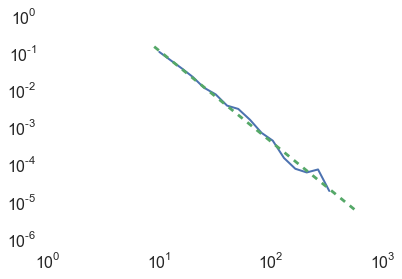

In [609]:
# Power law distribution!
%matplotlib inline
pl_testdata = np.array([x for x in vocab.itervalues()])
results = powerlaw.Fit(pl_testdata)
print results.power_law.alpha
print results.power_law.xmin
#R, p = results.distribution_compare('power_law', 'lognormal')
figCCDF = results.plot_pdf(linewidth=2)
results.power_law.plot_pdf(linestyle='--', ax=figCCDF)
#results.distribution_compare('power_law', 'truncated_power_law')


In [100]:
# For exporting to SECTION random forest model
section_corpus = [dictionary.doc2bow(song) for song in processed_corpus]

In [101]:
with open(r"C:\RTM\model\new.csv", 'w') as f:
    f.write(str(section_corpus))

In [55]:
# Create corpus matrix
dictionary = corpora.Dictionary(processed_corpus)
print dictionary
dictionary.save("""C:/mcgillout/billboardgensim.dict""")
corpus_bow = [dictionary.doc2bow(song) for song in processed_corpus]
corpora.MmCorpus.serialize("""C:/mcgillout/billboardgensim.mm""", corpus_bow)

# if TFIDF:
#     tfidf = models.TfidfModel(corpus_bow)
#     corpus_bow = tfidf[corpus_bow]

Dictionary(615 unique tokens: [u'0,4,c,maj___0,4,c,maj7', u'0,4,a-,7', u'0,4,c,maj___0,4,c,maj___0,4,c,maj', u'0,4,c,7___0,4,c,7___0,4,f,7___0,4,f,7', u'0,4,a-,1']...)


In [604]:
# Generate matlab-compatible data files
with open(r"C:\RTM\musicpmis.txt", 'w') as f:
    for token1, pmis in pmi_scores.iteritems():
        if token1 == ".":
            continue
        for token2, pmi in pmis.iteritems():
            if token2 == ".":
                continue
            print>>f, dictionary.token2id[token1] + 1, dictionary.token2id[token2] + 1, pmi


In [605]:
with open(r"C:\RTM\musicvocab.txt", 'w') as f:
    for token in sorted([x for x in dictionary.iteritems()], key = lambda x: x[0]):
        print>>f, token[1]

        
        

In [606]:
with open(r"C:\RTM\musicNdw.txt", 'w') as f:
    print>>f, dictionary.num_docs
    print>>f, len(dictionary.values())
    print>>f, sum(len(song) for song in processed_corpus)
    for i, song in enumerate(corpus_bow):
        for token in song:
            # aaaaa matlab indices aaaaaa
            print>>f, i + 1, token[0] + 1, token[1]


In [34]:
def topic_pmi(lda, i, top=10):
    topic = lda.show_topic(i, top)
    topic_words = [word[1] for word in topic]
    word_pairs = itertools.combinations(topic_words, 2)
    return np.mean([pmi_scores[word[0]][word[1]] for word in word_pairs])

def topic_word_pmis(lda, i, top=10):
    topic = lda.show_topic(i, top)
    topic_words = [word[1] for word in topic]
    word_pairs = itertools.product(topic_words, topic_words)
    pmis = defaultdict(int)
    for pair in word_pairs:
        if pair[0] != pair[1]:
            pmis[pair[0]] += pmi_scores[pair[0]][pair[1]]
    return pmis
        
        


##Hyperparameters for gensim's model
###Alpha
Sparsity of per-doc topic weights: higher <==== similar content in docs
###Eta
Sparsity of topic distributions:   higher ====> similar content in topics

In [48]:
# If you want to load a matlab model back into gensim
from scipy.io import loadmat 
wtm = loadmat(r"C:\RTM\model\nwt.mat")


In [102]:
#%time lda = gensim.models.wrappers.LdaVowpalWabbit("C:/users/dakota/vw/vw.exe", corpus=corpus_bow, id2word=dictionary, num_topics=20, passes = 16000, alpha = 3, eta = .99, chunksize=16)#, iterations=1000, passes=5)
%time lda = gensim.models.ldamodel.LdaModel(corpus=section_corpus, num_topics=16, id2word=dictionary, distributed=False, chunksize=20, passes=20, update_every=1, alpha='auto', eta=wtm['Nwt'].T, decay=0.5, offset=1024.0, eval_every=10, iterations=100, gamma_threshold=0.001)

Wall time: 59.1 s


In [12]:
# Evaluate various number-of-topic scores
k_vals = [5, 10, 15, 20, 25, 30, 35, 40]
#%time lda = gensim.models.wrappers.LdaVowpalWabbit("C:/users/dakota/vw/vw.exe", corpus=corpus_bow, id2word=dictionary, num_topics=20, passes = 16000, alpha = 3, eta = .99, chunksize=16)#, iterations=1000, passes=5)
for k in k_vals:
    lda = gensim.models.ldamodel.LdaModel(corpus=corpus_bow, num_topics=k, id2word=dictionary, distributed=False, chunksize=20, passes=10, update_every=1, alpha='auto', eta=None, decay=0.5, offset=1.0, eval_every=10, iterations=25000, gamma_threshold=0.001)
    print k
    topics = []
    for i, t in enumerate([topic.replace("+",u'\n') 
                       for topic 
                       in lda.print_topics(-1,10)]):
        pmi = topic_pmi(lda, i)
        topics.append((pmi, t))

    pmis.append([[t[0] for t in topics]])
    print "MEAN PMI: {}".format(np.mean([t[0] for t in topics]))
    for i, t in enumerate(sorted(topics, key=lambda x: x[0], reverse=True)):
        print "PMI: {}".format(t[0])
        print "TOPIC {}: {}".format(i + 1, t[1])
        print "\n----------------------------------------------------------------\n"


5
MEAN PMI: 0.376357595966
PMI: 0.619905451266
TOPIC 1: 0.089*S; 0,4,c,min___W; 0,4,c,min___S; 0,4,c,min___W; 0,4,c,min 
 0.057*S; 0,4,c,min7___W; 0,4,c,min7___S; 0,4,c,min7___W; 0,4,c,min7 
 0.032*S; 0,4,g,7___W; 0,4,g,7___S; 0,4,c,maj___W; 0,4,c,maj 
 0.027*S; 0,4,c,min 
 0.027*W; 0,4,c,min___S; 0,4,c,min___W; 0,4,c,min___S; 0,4,c,min 
 0.025*S; 0,4,c,maj___W; 0,4,c,maj___S; 0,4,a,min___W; 0,4,a,min 
 0.021*S; 0,4,c,min___W; 0,4,c,min___S; 0,4,b-,maj___W; 0,4,b-,maj 
 0.019*W; 0,4,b-,maj 
 0.018*W; 0,4,c,min 
 0.018*S; 0,4,c,min___W; 0,4,c,min

----------------------------------------------------------------

PMI: 0.519009199361
TOPIC 2: 0.162*S; 0,4,c,maj___W; 0,4,c,maj___S; 0,4,c,maj___W; 0,4,c,maj 
 0.062*S; 0,4,f,maj___W; 0,4,f,maj___S; 0,4,c,maj___W; 0,4,c,maj 
 0.041*S; 0,4,c,maj___W; 0,4,c,maj___S; 0,4,f,maj___W; 0,4,f,maj 
 0.037*W; 0,4,c,maj___S; 0,4,c,maj___W; 0,4,c,maj___S; 0,4,c,maj 
 0.034*S; 0,4,f,maj___W; 0,4,f,maj___S; 0,4,g,maj___W; 0,4,g,maj 
 0.020*W; 0,4,f,maj___S

In [30]:
[np.mean(pmi_list) for pmi_list in pmis]

[0.37635759596638918,
 0.55482829537707767,
 0.56354117365481327,
 0.64119495000688465,
 0.73067322891602227,
 0.78095068318533534,
 0.85648721349632795,
 0.80081262959222654]

In [58]:
topics = []
for i, t in enumerate([topic.replace("+",u'\n') 
                       for topic 
                       in lda.print_topics(-1,10)]):
    pmi = topic_pmi(lda, i)
    topics.append((pmi, t))

print "MEAN PMI: {}".format(np.mean([t[0] for t in topics]))
for i, t in enumerate(sorted(topics, key=lambda x: x[0], reverse=True)):
    print "PMI: {}".format(t[0])
    print "TOPIC {}: {}".format(i + 1, t[1])
    print "\n----------------------------------------------------------------\n"


MEAN PMI: 0.269278560319
PMI: 0.945746743118
TOPIC 1: 0.112*0,4,c,7(#9)___0,4,c,7(#9)___0,4,c,7(#9)___0,4,c,7(#9) 
 0.093*0,4,b-,maj 
 0.065*0,4,c,min7 
 0.063*0,4,a-,maj 
 0.062*0,4,f,min7 
 0.053*0,4,f,7 
 0.053*0,4,e-,maj 
 0.043*0,4,a-,maj7 
 0.039*0,4,c,7 
 0.038*0,4,a-,maj___0,4,b-,maj

----------------------------------------------------------------

PMI: 0.8058060846
TOPIC 2: 0.092*0,4,g,maj___0,4,c,maj 
 0.058*0,4,c,maj___0,4,a,min___0,4,c,maj___0,4,a,min 
 0.057*0,4,c,maj___0,4,a,min 
 0.050*0,4,g,maj 
 0.044*0,4,a,min___0,4,g,maj 
 0.032*0,4,a,min___0,4,f,maj___0,4,g,maj___0,4,c,maj 
 0.029*0,4,g,maj___0,4,a,min 
 0.025*0,4,a,min___0,4,d,maj 
 0.023*0,4,c,maj___0,4,a,min7 
 0.023*0,4,e,min___0,4,a,min

----------------------------------------------------------------

PMI: 0.800320930787
TOPIC 3: 0.350*0,4,c,7___0,4,c,7___0,4,c,7___0,4,c,7 
 0.098*0,4,f,7___0,4,f,7___0,4,c,7___0,4,c,7 
 0.049*0,4,c,7___0,4,c,7 
 0.042*0,4,c,7___0,4,c,7___0,4,f,7___0,4,f,7 
 0.042*0,4,g,7___0,

In [102]:
topics = []
for i, t in enumerate([topic.replace("+",u'\n') 
                       for topic 
                       in lda.print_topics(-1,10)]):
    pmi = topic_pmi(lda, i)
    topics.append((pmi, t))

print "MEAN PMI: {}".format(np.mean([t[0] for t in topics]))
for i, t in enumerate(sorted(topics, key=lambda x: x[0], reverse=True)):
    print "PMI: {}".format(t[0])
    print "TOPIC {}: {}".format(i + 1, t[1])
    print "\n----------------------------------------------------------------\n"


MEAN PMI: 0.674232133746
PMI: 1.33783393715
TOPIC 1: 0.172*0,4,a,min 
 0.164*0,4,g,maj___0,4,g,maj 
 0.121*0,4,f,maj___0,4,f,maj 
 0.065*0,4,f,maj___0,4,f,maj___0,4,c,maj___0,4,c,maj 
 0.061*0,4,f,maj___0,4,f,maj___0,4,g,maj___0,4,g,maj 
 0.046*0,4,a,min___0,4,f,maj 
 0.035*0,4,g,maj___0,4,g,maj___0,4,f,maj___0,4,f,maj 
 0.035*0,4,c,maj___0,4,g,7 
 0.022*0,4,c,maj___0,4,c,maj___0,4,g,maj___0,4,g,maj 
 0.020*0,2,g,maj; 2,2,g,maj___0,2,g,maj; 2,2,g,maj

----------------------------------------------------------------

PMI: 1.15698678779
TOPIC 2: 0.165*0,4,b-,maj 
 0.136*0,4,e-,maj 
 0.045*0,2,c,maj; 2,2,f,maj___0,2,c,maj; 2,2,f,maj___0,2,c,maj; 2,2,f,maj___0,2,c,maj; 2,2,f,maj___0,2,c,maj; 2,2,f,maj___0,2,c,maj; 2,2,f,maj___0,2,c,maj; 2,2,f,maj___0,2,c,maj; 2,2,f,maj 
 0.038*0,4,c,maj___0,4,c,maj___0,4,b-,maj___0,4,b-,maj___0,4,f,maj___0,4,f,maj___0,4,c,maj___0,4,c,maj 
 0.037*0,2,c,maj; 2,2,f,maj___0,2,c,maj; 2,2,f,maj___0,2,c,maj; 2,2,f,maj 
 0.036*0,2,c,maj; 2,2,b-,maj 
 0.034*0,2,f,m

In [104]:
topics = []
for i, t in enumerate([topic.replace("+",u'\n') 
                       for topic 
                       in lda.print_topics(-1,10)]):
    pmi = topic_pmi(lda, i)
    topics.append((pmi, t))

print "MEAN PMI: {}".format(np.mean([t[0] for t in topics]))
for i, t in enumerate(sorted(topics, key=lambda x: x[0], reverse=True)):
    print "PMI: {}".format(t[0])
    print "TOPIC {}: {}".format(i + 1, t[1])
    print "\n----------------------------------------------------------------\n"


MEAN PMI: 0.667642932155
PMI: 1.62592255928
TOPIC 1: 0.182*0,4,c,min___0,4,c,min___0,4,c,min___0,4,c,min___0,4,c,min___0,4,c,min___0,4,c,min___0,4,c,min 
 0.139*0,4,c,min7___0,4,c,min7___0,4,c,min7___0,4,c,min7___0,4,c,min7___0,4,c,min7___0,4,c,min7___0,4,c,min7 
 0.115*0,4,c,min___0,4,c,min___0,4,c,min___0,4,c,min 
 0.072*0,4,c,min___0,4,c,min 
 0.065*0,4,a-,maj___0,4,a-,maj 
 0.030*0,4,f,maj___0,4,f,maj___0,4,f,maj___0,4,f,maj 
 0.025*0,4,e-,maj___0,4,b-,maj 
 0.024*0,4,c,min___0,4,c,min___0,4,b-,maj___0,4,b-,maj 
 0.023*0,4,f,min___0,4,f,min 
 0.021*0,4,c,min___0,4,c,min___0,4,c,min___0,4,c,min___0,4,c,min___0,4,c,min

----------------------------------------------------------------

PMI: 1.27820153365
TOPIC 2: 0.553*0,4,c,maj 
 0.087*0,4,c,7 
 0.032*0,2,f,maj 
 0.023*0,4,c,maj___0,4,a,min___0,4,f,maj___0,4,g,maj 
 0.021*0,4,c,maj___0,4,c,maj___0,4,a,min___0,4,f,maj 
 0.017*0,2,f,maj___2,2,g,maj 
 0.014*2,2,f,min 
 0.013*2,2,a,min 
 0.012*0,4,f,maj___0,4,g,maj___0,4,c,maj 
 0.011*2,

In [138]:
topics = []
for i, t in enumerate([topic.replace("+",u'\n') 
                       for topic 
                       in lda.print_topics(-1,10)]):
    pmi = topic_pmi(lda, i)
    topics.append((pmi, t))

print "MEAN PMI: {}".format(np.mean([t[0] for t in topics]))
for i, t in enumerate(sorted(topics, key=lambda x: x[0], reverse=True)):
    print "PMI: {}".format(t[0])
    print "TOPIC {}: {}".format(i + 1, t[1])
    print "\n----------------------------------------------------------------\n"


MEAN PMI: 1.02857142505
PMI: 2.68908736792
TOPIC 1: 0.055*0,4,c,maj___0,4,d,min7___0,4,b-,maj___0,4,c,maj___0,4,c,maj___0,4,d,min7___0,4,b-,maj___0,4,c,maj 
 0.026*0,4,c,1___0,4,d,1___0,4,b-,1___0,4,c,1___0,4,c,1___0,4,d,1___0,4,b-,1___0,4,c,1 
 0.024*0,3,f,maj___0,3,g,maj 
 0.020*0,4,c,maj___0,4,d,min___0,4,b-,maj___0,4,c,maj___0,4,c,maj___0,4,d,min___0,4,b-,maj___0,4,c,maj 
 0.017*0,3,c,sus4___0,3,c,maj 
 0.014*0,3,a,min 
 0.014*0,3,g,maj___0,3,f,maj 
 0.012*0,4,b-,maj___0,2,f,maj; 2,2,f,maj6 
 0.010*0,3,g,maj___0,3,g,maj 
 0.010*0,3,d,min

----------------------------------------------------------------

PMI: 1.89237417834
TOPIC 2: 0.109*0,4,c,7___0,4,c,7___0,4,c,7___0,4,c,7___0,4,c,7___0,4,c,7___0,4,c,7___0,4,c,7 
 0.062*0,4,c,7 
 0.044*0,4,f,7 
 0.040*0,4,c,7___0,4,c,7 
 0.028*0,4,c,7___0,4,c,7___0,4,c,7___0,4,c,7 
 0.018*0,4,f,7___0,4,c,7 
 0.017*0,4,f,7___0,4,f,7 
 0.013*0,4,g,7___0,4,f,7 
 0.013*0,4,b-,7___0,4,b-,7 
 0.012*0,4,c,7___0,4,c,7___0,4,c,7

--------------------------

In [33]:
topics = []
for i, t in enumerate([topic.replace("+",u'\n') 
                       for topic 
                       in lda.print_topics(-1,10)]):
    pmi = topic_pmi(lda, i)
    topics.append((pmi, t))

print "MEAN PMI: {}".format(np.mean([t[0] for t in topics]))
for i, t in enumerate(sorted(topics, key=lambda x: x[0], reverse=True)):
    print "PMI: {}".format(t[0])
    print "TOPIC {}: {}".format(i + 1, t[1])
    print "\n----------------------------------------------------------------\n"


NameError: name 'topic_pmi' is not defined

In [177]:
topics = []
for i, t in enumerate([topic.replace("+",u'\n') 
                       for topic 
                       in lda.print_topics(-1,10)]):
    pmi = topic_pmi(lda, i)
    topics.append((pmi, t))

print "MEAN PMI: {}".format(np.mean([t[0] for t in topics]))
for i, t in enumerate(sorted(topics, key=lambda x: x[0], reverse=True)):
    print "PMI: {}".format(t[0])
    print "TOPIC {}: {}".format(i + 1, t[1])
    print "\n----------------------------------------------------------------\n"


MEAN PMI: 1.24983948797
PMI: 4.33352963351
TOPIC 1: 0.022*0,3,c,maj___0,3,c,maj 
 0.022*0,3,f,maj 
 0.021*0,3,c,maj 
 0.014*0,3,c,maj___0,3,g,7___0,3,c,maj___0,3,c,maj 
 0.013*0,3,f,maj___0,3,g,maj 
 0.012*0,3,g,7___0,3,g,7___0,3,g,7___0,3,g,7 
 0.012*0,3,f,maj___0,3,f,maj 
 0.011*0,3,f,maj___0,3,c,maj 
 0.011*0,3,c,7___0,3,f,maj 
 0.011*0,3,g,maj___0,3,c,maj

----------------------------------------------------------------

PMI: 2.07371924601
TOPIC 2: 0.078*0,4,c,min___0,4,c,min___0,4,c,min___0,4,c,min___0,4,c,min___0,4,c,min___0,4,c,min___0,4,c,min 
 0.060*0,4,c,min7___0,4,c,min7___0,4,c,min7___0,4,c,min7___0,4,c,min7___0,4,c,min7___0,4,c,min7___0,4,c,min7 
 0.047*0,4,c,min___0,4,c,min___0,4,c,min___0,4,c,min 
 0.029*0,4,c,min___0,4,c,min 
 0.018*0,4,a-,maj___0,4,a-,maj 
 0.017*0,4,a-,maj7___0,4,a-,maj7 
 0.016*0,4,c,min7___0,4,c,min7___0,4,c,min7___0,4,c,min7 
 0.014*0,4,c,min7___0,4,c,min7 
 0.010*0,4,c,min___0,4,c,min___0,4,b-,maj___0,4,b-,maj 
 0.009*0,4,c,min___0,4,c,min___0,4,c

In [314]:
topics = []
for i, t in enumerate([topic.replace("+",u'\n') 
                       for topic 
                       in lda.print_topics(-1,10)]):
    pmi = topic_pmi(lda, i)
    topics.append((pmi, t, i))

print "MEAN PMI: {}".format(np.mean([t[0] for t in topics]))
for i, t in enumerate(sorted(topics, key=lambda x: x[0], reverse=True)):
    print "PMI: {}".format(t[0])
    print "TOPIC {} (originally {}): {}".format(i + 1, t[2], t[1])
    print "\n----------------------------------------------------------------\n"


MEAN PMI: 0.676825021995
PMI: 4.47967073636
TOPIC 1 (originally 7): 0.124*0,3,c,maj___0,3,c,maj 
 0.067*0,3,f,maj___0,3,f,maj 
 0.063*0,3,g,7___0,3,g,7 
 0.056*0,3,g,maj___0,3,g,maj 
 0.045*0,3,c,maj___0,3,g,7 
 0.036*0,3,f,maj___0,3,c,maj 
 0.036*0,3,f,maj___0,3,g,maj 
 0.034*0,3,c,maj 
 0.033*0,3,g,7___0,3,c,maj 
 0.028*0,3,g,maj___0,3,c,maj

----------------------------------------------------------------

PMI: 2.50860570073
TOPIC 2 (originally 22): 0.099*0,4,a,min7___0,4,a,min7 
 0.047*0,4,a,min9___0,4,g,maj7/9 
 0.043*0,4,f,maj9/3___0,4,g,maj7 
 0.031*0,2,a,min7; 2,2,e,min7___0,2,d,min7; 2,2,g,sus4(b7) 
 0.031*0,4,a,min7___0,2,e,min; 2,2,f,maj7 
 0.031*0,2,c,sus4(9); 2,2,c,maj___0,4,c,maj(9) 
 0.028*0,4,g,7___0,4,c,maj7 
 0.028*0,2,c,maj(9); 2,2,a,min7(11)___0,2,g,sus4; 2,2,g,maj 
 0.028*0,4,g,maj___0,4,b-,maj9 
 0.024*0,4,f,maj9___0,4,g,maj7

----------------------------------------------------------------

PMI: 1.72633976268
TOPIC 3 (originally 0): 0.519*0,4,c,min7___0,4,c,min7 

In [323]:
for k in xrange(35):
    print k
    print topic_word_pmis(lda,k)
    print "\n" + "-"*70 + "\n"

0
defaultdict(<type 'int'>, {u'0,4,d,maj___0,4,b,min': 13.921963262003219, u'0,4,a,maj___0,4,a,maj': 29.284061273778267, u'0,4,g,maj___0,4,a,maj': 9.39806300766774, u'0,4,d,maj___0,4,d,maj': 18.48877060944988, u'0,4,a,maj___0,4,d,maj': 15.9508203294531, u'0,4,d,maj___0,4,g,maj': 8.33409728563375, u'0,4,g,maj___0,4,g,maj': 5.194431826127522, u'0,4,g,maj___0,4,c,maj': 9.060996678553936, u'0,4,e,maj___0,4,e,maj': 3.2852870179150457, u'0,4,e,min': 4.168432351868626})

----------------------------------------------------------------------

1
defaultdict(<type 'int'>, {u'0,4,a,min___0,4,g,maj': 6.0569559347958535, u'0,4,c,maj7___0,4,a,min': 6.437553561681644, u'0,4,a,min': 6.578602136771956, u'0,4,f,min6___0,4,g,7': 40.26617032727901, u'0,2,g,sus4; 2,2,g,maj': -3.309175366311072, u'0,4,c,maj(9)___0,4,g,maj/11': 28.017824314961523, u'0,4,a,7___0,4,d,min7': 4.3557519822135, u'0,4,c,maj7': 1.5686402805998423, u'0,4,f,maj6': 13.20463755160591, u'0,4,g,7': 7.832310264262654})

-------------------

In [326]:
for k in xrange(35):
    print k,
    print np.mean([val for val in topic_word_pmis(lda,k).itervalues()])

0 11.7086923642
1 11.1009270988
2 9.16050113706
3 2.84700450057
4 0.785242264196
5 3.97455354449
6 7.44688277843
7 13.8800946662
8 10.9775882116
9 17.1729906997
10 3.56217749417
11 2.07074443995
12 9.35556979043
13 7.42120567552
14 11.7905315847
15 11.0637181504
16 -7.20047190628
17 22.5120660841
18 19.3525078975
19 6.18621855101
20 39.4143627973
21 -7.20047190628
22 4.52079707138
23 -7.20047190628
24 5.20966529211
25 0.783433600779
26 -7.20047190628
27 3.91734387784
28 40.9633724143
29 8.71908167659
30 17.1387849926
31 2.82543669243
32 3.26752316622
33 27.2774068706
34 15.5527551497


In [121]:
import re
labels = [re.sub(r'[0-9]+[_]?([a-z]+)', r'\1',title) for title in kept_songs]

In [115]:
pd.DataFrame(song_topics)

,0,1,2,3,4,5,6,7
0,"(0, 0.107505831583)","(2, 0.0872472588042)","(3, 0.0775026742462)","(5, 0.0666191421029)","(9, 0.0813069091962)","(10, 0.232744375266)","(11, 0.052357711491)","(12, 0.0627224435195)"
1,"(0, 0.107505831583)","(2, 0.0872472588042)","(3, 0.0775026742462)","(5, 0.0666191421029)","(9, 0.0813069091962)","(10, 0.232744375266)","(11, 0.052357711491)","(12, 0.0627224435195)"
2,"(0, 0.107505831583)","(2, 0.0872472588042)","(3, 0.0775026742462)","(5, 0.0666191421029)","(9, 0.0813069091962)","(10, 0.232744375266)","(11, 0.052357711491)","(12, 0.0627224435195)"
3,"(3, 0.70727666101)","(10, 0.0738535589826)",None,None,None,None,None,None
4,"(3, 0.70727666101)","(10, 0.0738535589826)",None,None,None,None,None,None
5,"(3, 0.903963779343)",None,None,None,None,None,None,None
6,"(0, 0.0517921837487)","(7, 0.532353876744)","(10, 0.112127307633)",None,None,None,None,None
7,"(1, 0.0517385851754)","(3, 0.906793428401)",None,None,None,None,None,None
8,"(0, 0.107505831583)","(2, 0.0872472588042)","(3, 0.0775026742462)","(5, 0.0666191421029)","(9, 0.0813069091962)","(10, 0.232744375266)","(11, 0.052357711491)","(12, 0.0627224435195)"
9,"(0, 0.107505831583)","(2, 0.0872472588042)","(3, 0.0775026742462)","(5, 0.0666191421029)","(9, 0.0813069091962)","(10, 0.232744375266)","(11, 0.052357711491)","(12, 0.0627224435195)"


In [127]:
topic_threshold = .05
song_topics = [lda[song] for song in section_corpus]
song_topics = [[topic for topic in topics if topic[1] >= topic_threshold]
                  for topics in song_topics]


doc_counts = defaultdict(int)
for song in song_topics:
    for topic in song:
        if topic[1] >= .5:
            doc_counts[topic[0] + 1] += 1
        
    
# topics w/ high doc frequency but low proportion are "generic"
# count num docs s.t. prob of k > thresh
sts = np.zeros((len(section_corpus), 16))

for i, song in enumerate(song_topics):
    for topic in song:
        sts[i][topic[0]] = topic[1]
        
song_topics = pd.DataFrame(sts)
        

# or count num docs s.t. topic k is largest

In [128]:
song_topics['label'] = labels

In [132]:
song_topics.to_pickle("C:\RTM\model\sections.csv")

In [62]:
for i, t in enumerate([topic.replace("+",u'\n') 
                       for topic 
                       in lda.print_topics(-1)]):
    print "TOPIC {}: {}".format(i + 1, t)
    print "\n----------------------------------------------------------------\n"


TOPIC 1: 0.211*0,4,c,maj___0,4,c,maj 
 0.044*0,2,c,maj---2,2,f,maj___0,2,c,maj---2,2,f,maj___0,2,c,maj---2,2,f,maj___0,2,c,maj---2,2,f,maj 
 0.043*0,4,c,1___0,4,c,1___0,4,c,1___0,4,c,1 
 0.026*0,4,c,1___0,4,c,1 
 0.018*0,4,g,sus4(b7) 
 0.018*0,4,g,sus4(b7)___0,4,g,sus4(b7) 
 0.018*0,4,d,min7___0,4,d,min7 
 0.017*0,4,a,min9___0,4,g,maj7/9___0,4,f,maj9/3___0,4,g,maj7 
 0.017*0,4,c,maj9 
 0.016*0,4,f,maj7___0,4,f,maj7

----------------------------------------------------------------

TOPIC 2: 0.108*0,4,c,5 
 0.103*0,4,c,5___0,4,c,5___0,4,c,5___0,4,c,5 
 0.100*0,4,c,5___0,4,c,5 
 0.072*0,2,a-,maj---2,2,b-,maj 
 0.051*0,4,c,maj___0,4,f,maj___0,4,g,7___0,4,c,maj 
 0.037*0,4,c,1 
 0.037*0,4,e-,5 
 0.031*0,4,c,maj___0,2,b-,maj---2,2,f,maj___0,4,c,maj___0,2,b-,maj---2,2,f,maj 
 0.031*0,4,f,5___0,4,f,5 
 0.029*0,4,c,min___0,4,c,min___0,4,e-,maj___0,4,e-,maj

----------------------------------------------------------------

TOPIC 3: 0.121*0,4,g,maj___0,4,g,maj 
 0.077*0,4,f,maj___0,4,g,maj 
 0.04

In [78]:
# CHORD QUALITY LDA
# no ngrams
for i, t in enumerate([topic.replace("+",u'\n') 
                       for topic 
                       in lda.print_topics(-1)]):
    print "TOPIC {}: {}".format(i + 1, t)
    print "\n----------------------------------------------------------------\n"


TOPIC 1: 0.211*0,4,c,maj___0,4,c,maj 
 0.044*0,2,c,maj---2,2,f,maj___0,2,c,maj---2,2,f,maj___0,2,c,maj---2,2,f,maj___0,2,c,maj---2,2,f,maj 
 0.043*0,4,c,1___0,4,c,1___0,4,c,1___0,4,c,1 
 0.026*0,4,c,1___0,4,c,1 
 0.019*0,4,g,sus4(b7)___0,4,g,sus4(b7) 
 0.018*0,4,g,sus4(b7) 
 0.018*0,4,d,min7___0,4,d,min7 
 0.017*0,4,a,min9___0,4,g,maj7/9___0,4,f,maj9/3___0,4,g,maj7 
 0.017*0,4,c,maj9 
 0.016*0,4,f,maj7___0,4,f,maj7

----------------------------------------------------------------

TOPIC 2: 0.109*0,4,c,5 
 0.103*0,4,c,5___0,4,c,5___0,4,c,5___0,4,c,5 
 0.102*0,4,c,5___0,4,c,5 
 0.071*0,2,a-,maj---2,2,b-,maj 
 0.051*0,4,c,maj___0,4,f,maj___0,4,g,7___0,4,c,maj 
 0.038*0,4,c,1 
 0.036*0,4,e-,5 
 0.031*0,4,f,5___0,4,f,5 
 0.031*0,4,c,maj___0,2,b-,maj---2,2,f,maj___0,4,c,maj___0,2,b-,maj---2,2,f,maj 
 0.029*0,4,c,min___0,4,c,min___0,4,e-,maj___0,4,e-,maj

----------------------------------------------------------------

TOPIC 3: 0.121*0,4,g,maj___0,4,g,maj 
 0.077*0,4,f,maj___0,4,g,maj 
 0.04

In [104]:
[lda[song] for song in section_corpus]

[[(0, 0.1075058315828603),
  (1, 0.033487049873313822),
  (2, 0.087247258804177691),
  (3, 0.07750267424621976),
  (4, 0.028599083141360386),
  (5, 0.066619142102941661),
  (6, 0.020972181567439258),
  (7, 0.029299756675456767),
  (8, 0.032862559348965419),
  (9, 0.081306909196236996),
  (10, 0.23274437526570541),
  (11, 0.052357711491003503),
  (12, 0.062722443519516391),
  (13, 0.018962997498016606),
  (14, 0.023300449634125968),
  (15, 0.044509576052659955)],
 [(0, 0.1075058315828603),
  (1, 0.033487049873313822),
  (2, 0.087247258804177691),
  (3, 0.07750267424621976),
  (4, 0.028599083141360386),
  (5, 0.066619142102941661),
  (6, 0.020972181567439258),
  (7, 0.029299756675456767),
  (8, 0.032862559348965419),
  (9, 0.081306909196236996),
  (10, 0.23274437526570541),
  (11, 0.052357711491003503),
  (12, 0.062722443519516391),
  (13, 0.018962997498016606),
  (14, 0.023300449634125968),
  (15, 0.044509576052659955)],
 [(0, 0.1075058315828603),
  (1, 0.033487049873313822),
  (2, 0.08

In [103]:
# no ngrams
for i, t in enumerate([topic.replace("+",u'\n') 
                       for topic 
                       in lda.print_topics(-1)]):
    print "TOPIC {}: {}".format(i + 1, t)
    print "\n----------------------------------------------------------------\n"


TOPIC 1: 0.215*0,4,c,maj___0,4,c,maj 
 0.040*0,2,c,maj---2,2,f,maj___0,2,c,maj---2,2,f,maj___0,2,c,maj---2,2,f,maj___0,2,c,maj---2,2,f,maj 
 0.039*0,4,c,1___0,4,c,1___0,4,c,1___0,4,c,1 
 0.027*0,4,d,min7___0,4,d,min7 
 0.025*0,4,c,1___0,4,c,1 
 0.021*0,4,e,min7___0,4,e,min7 
 0.020*0,4,g,sus4(b7)___0,4,g,sus4(b7) 
 0.018*0,4,f,maj7___0,4,f,maj7 
 0.017*0,4,c,maj9 
 0.015*0,4,c,maj___0,4,g,7___0,4,g,7___0,4,c,maj

----------------------------------------------------------------

TOPIC 2: 0.105*0,4,c,5___0,4,c,5___0,4,c,5___0,4,c,5 
 0.090*0,4,c,5 
 0.083*0,4,c,5___0,4,c,5 
 0.066*0,4,c,maj___0,4,f,maj___0,4,g,7___0,4,c,maj 
 0.064*0,2,a-,maj---2,2,b-,maj 
 0.056*0,4,e-,5 
 0.048*0,4,c,maj___0,2,b-,maj---2,2,f,maj___0,4,c,maj___0,2,b-,maj---2,2,f,maj 
 0.042*0,4,c,1 
 0.035*0,4,f,5___0,4,f,5 
 0.031*0,4,c,5(b7)

----------------------------------------------------------------

TOPIC 3: 0.116*0,4,g,maj___0,4,g,maj 
 0.081*0,4,g,maj 
 0.070*0,4,f,maj___0,4,g,maj 
 0.056*0,4,c,min7___0,4,c,

In [143]:
# Random latex formatting
data = [(u'0,4,c,maj___0,4,c,maj___0,4,b-,maj___0,4,b-,maj', 19),
 (u'0,4,f,maj___0,4,g,maj___0,4,c,maj___0,4,c,maj', 19),
 (u'0,4,c,maj___0,4,f,maj___0,4,c,maj___0,4,c,maj', 18),
 (u'0,4,d,min___0,4,d,min', 18),
 (u'0,4,c,min___0,2,a-,maj---2,2,b-,maj___0,4,c,min___0,2,a-,maj---2,2,b-,maj',
  18),
 (u'0,2,a-,maj---2,2,b-,maj', 18),
 (u'0,4,a,min___0,4,f,maj', 18),
 (u'0,4,c,min___0,4,c,min/b7___0,4,c,min/13___0,2,a-,maj7---2,2,g,7', 18),
 (u'0,4,a,maj', 18),
 (u'0,2,g,sus4---2,2,g,maj', 18)]
import pandas as pd
import numpy as np
print " \\\\\n".join([" & ".join(map(str,line)) for line in data]) + " \\\\"

0,4,c,maj___0,4,c,maj___0,4,b-,maj___0,4,b-,maj & 19 \\
0,4,f,maj___0,4,g,maj___0,4,c,maj___0,4,c,maj & 19 \\
0,4,c,maj___0,4,f,maj___0,4,c,maj___0,4,c,maj & 18 \\
0,4,d,min___0,4,d,min & 18 \\
0,4,c,min___0,2,a-,maj---2,2,b-,maj___0,4,c,min___0,2,a-,maj---2,2,b-,maj & 18 \\
0,2,a-,maj---2,2,b-,maj & 18 \\
0,4,a,min___0,4,f,maj & 18 \\
0,4,c,min___0,4,c,min/b7___0,4,c,min/13___0,2,a-,maj7---2,2,g,7 & 18 \\
0,4,a,maj & 18 \\
0,2,g,sus4---2,2,g,maj & 18 \\


In [140]:
vocab = dict()
for song in processed_corpus:
    for word in song:
        if word not in vocab:
            vocab[word] = 0
        vocab[word] += 1
            
vocab_sorted = filter(lambda x: x[1] > 25, sorted(vocab.items(), key=lambda x: x[1], reverse=True))
wordids = {v[0]: i for i, v in enumerate(vocab_sorted)}
idwords = {i: v[0] for i, v in enumerate(vocab_sorted)}
vocab_size = len(wordids)
print vocab_size
data = []
for song in processed_corpus:
    data.append([0]*vocab_size)
    for word in song:
        if word in wordids:
            data[-1][wordids[word]] += 1

vocab

182


{u'0,1,f,min/5---1,3,c,maj': 2,
 u'0,4,a-,7': 17,
 u'0,4,c,maj___0,4,c,maj___0,4,c,maj': 62,
 u'0,4,a-,5': 1,
 u'0,4,c,maj___0,4,a,min7___0,4,b-,maj___0,4,g,min': 16,
 u'0,2,e#,maj---2,2,d,maj': 4,
 u'0,1,a-,maj7---1,1,g,min7---2,2,f,min7___0,1,f,maj/9---1,3,f,min7': 1,
 u'0,2,g,1---2,2,a,1': 3,
 u'0,4,c,maj___0,4,c,maj___0,4,c,maj___0,4,b-,maj': 11,
 u'0,2,c,maj---2,1,f,maj7': 2,
 u'0,4,a-,9': 9,
 u'0,2,c,maj---0,2,c,maj---0,2,f,maj': 2,
 u'0,2,d,min7---0,2,c,maj7---0,2,f,maj': 1,
 u'0,4,a-,maj___0,2,d-,maj---2,2,a-,maj___0,4,e-,7___0,2,b-,maj---2,2,e-,7': 6,
 u'0,4,d,min9___0,4,g,sus4(b7,9)': 2,
 u'0,2,a-,maj/3---2,2,d-,maj': 1,
 u'0,3,a,min___0,3,a,min___0,3,g,maj___0,3,g,maj': 9,
 u'0,4,d,min7/5': 5,
 u'0,4,b,maj7/9___0,4,f#,maj9___0,2,b,maj9---2,2,e,maj/#11___0,1,e,maj/#11---1,2,f#,maj/3---3,1,g#,maj/3': 8,
 u'0,2,e--,maj6(9)/5---2,2,b--,7': 3,
 u'0,2,b-,5---2,2,f,5': 4,
 u'0,2,f,maj---2,2,d,9/3': 5,
 u'0,2,c,7---2,2,c,sus4(b7,9)': 1,
 u'0,4,d,min___0,4,g,sus4(b7,9)': 3,
 u'0,4,g,

In [139]:
vocab

{u'0,1,f,min/5---1,3,c,maj': 2,
 u'0,4,a-,7': 17,
 u'0,4,c,maj___0,4,c,maj___0,4,c,maj': 62,
 u'0,4,a-,5': 1,
 u'0,4,c,maj___0,4,a,min7___0,4,b-,maj___0,4,g,min': 16,
 u'0,2,e#,maj---2,2,d,maj': 4,
 u'0,1,a-,maj7---1,1,g,min7---2,2,f,min7___0,1,f,maj/9---1,3,f,min7': 1,
 u'0,2,g,1---2,2,a,1': 3,
 u'0,4,c,maj___0,4,c,maj___0,4,c,maj___0,4,b-,maj': 11,
 u'0,2,c,maj---2,1,f,maj7': 2,
 u'0,4,a-,9': 9,
 u'0,2,c,maj---0,2,c,maj---0,2,f,maj': 2,
 u'0,2,d,min7---0,2,c,maj7---0,2,f,maj': 1,
 u'0,4,a-,maj___0,2,d-,maj---2,2,a-,maj___0,4,e-,7___0,2,b-,maj---2,2,e-,7': 6,
 u'0,4,d,min9___0,4,g,sus4(b7,9)': 2,
 u'0,2,a-,maj/3---2,2,d-,maj': 1,
 u'0,3,a,min___0,3,a,min___0,3,g,maj___0,3,g,maj': 9,
 u'0,4,d,min7/5': 5,
 u'0,4,b,maj7/9___0,4,f#,maj9___0,2,b,maj9---2,2,e,maj/#11___0,1,e,maj/#11---1,2,f#,maj/3---3,1,g#,maj/3': 8,
 u'0,2,e--,maj6(9)/5---2,2,b--,7': 3,
 u'0,2,b-,5---2,2,f,5': 4,
 u'0,2,f,maj---2,2,d,9/3': 5,
 u'0,2,c,7---2,2,c,sus4(b7,9)': 1,
 u'0,4,d,min___0,4,g,sus4(b7,9)': 3,
 u'0,4,g,

In [507]:
import numpy as np
import pymc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
sns.set_context("poster")
sns.set_style("darkgrid")
%matplotlib inline



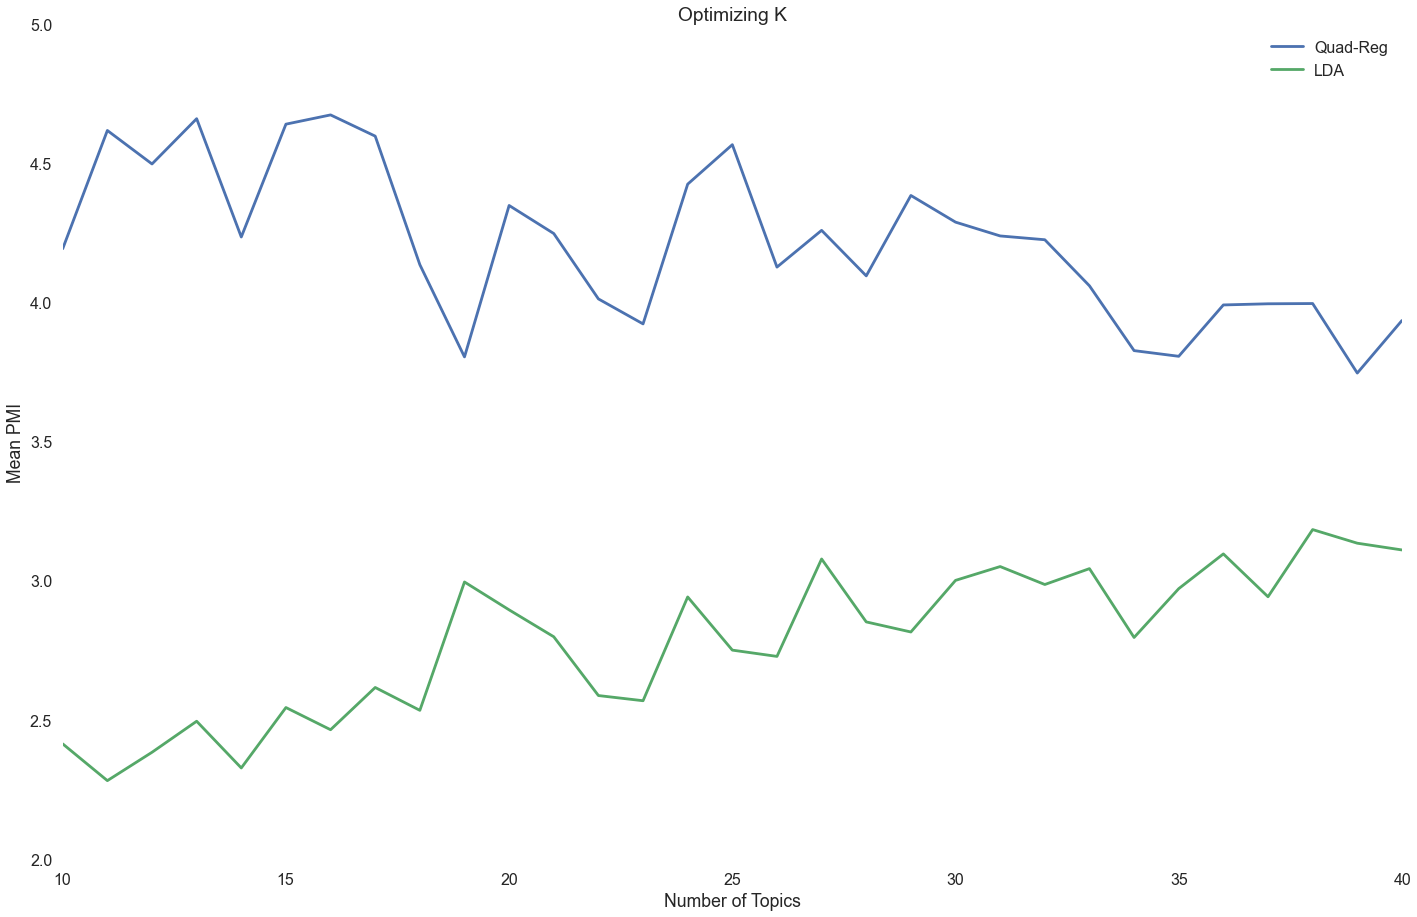

In [608]:
regular_PMIS = [4.4573,4.8566,4.4581,4.8011,4.5256,5.4191,5.1234,5.3516,5.6013,5.2254,5.7116,5.5330,5.8729,5.6891,6.7217,6.4974,6.2809,5.8080,5.7663,6.6012,6.1735,6.1230,6.9068,6.4005,6.3194,6.7346,6.8459,6.7014,6.8291,6.2753,6.6680,6.9476,6.6029,7.1433,7.0338,6.9795]
topic_PMIS = [11.4283,9.4140,9.6672,9.4056,8.6107,9.4033,10.3545,10.0851,10.4493,9.4975,10.4053,10.4798,10.3090,9.2748,8.5327,9.7511,9.5254,8.9994,8.7983,9.9227,10.2403,9.2553,9.5509,9.1848,9.8316,9.6171,9.5060,9.4754,9.1048,8.5833,8.5376,8.9508,8.9601,8.9621,8.4028,8.8254]
# whooooooops

regular_PMIS = [x*0.446428571 for x in regular_PMIS]
topic_PMIS = [x*0.446428571 for x in topic_PMIS]

fig = plt.figure(figsize=(24,16), dpi=100)
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Optimizing K')

ax.set_xlabel('Number of Topics')
ax.set_ylabel('Mean PMI')

a = ax.plot(xrange(10,41), topic_PMIS[5:], label='Quad-Reg')
b = ax.plot(xrange(10,41), regular_PMIS[5:], label = 'LDA')

ax.legend()

# This agress with Lau et al 2013
# For smaller #topics, topic models try to be broad
# things at lower hierarchical levels are 
# forced into their own topics by the regularized model cause of cooccurrence
# so for low T there's more general stuff available for the higher-up-hierarchy 
# maybe do a secondary thresholding -- 
# if a word is 1? 2? SD below the mean, cull it from a topic